In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

# Divide data by displacement reason

In [16]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm2_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_districts.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
pop_density = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/population_density.csv")

In [17]:
from haversine import haversine, Unit

states_gdf['ADM2_EN'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)
states_gdf['centroid'] = states_gdf.geometry.centroid

# Initialize an empty DataFrame
dist_matrix = pd.DataFrame(index=states_gdf['ADM2_EN'], columns=states_gdf['ADM2_EN'])

# Calculate the haversine distance between each pair of districts
for i, dis1 in enumerate(states_gdf['ADM2_EN']):
    for j, dis2 in enumerate(states_gdf['ADM2_EN']):
        dist_matrix.loc[dis1, dis2] = haversine(states_gdf.loc[i, 'centroid'].coords[0], states_gdf.loc[j, 'centroid'].coords[0])

dist_matrix.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_districts.csv")

/tmp/ipykernel_40072/4067426565.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf['centroid'] = states_gdf.geometry.centroid


In [18]:
disp_data_d = disp_data[(disp_data['Reason']=='Drought related')]
disp_data_f = disp_data[(disp_data['Reason']=='Flood')]
disp_data_fd = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_c = disp_data[(disp_data['Reason']=='Conflict/Insecurity')]

agg_d=np.empty(5, dtype=object)
disp_matxs_d=np.empty(5, dtype=object)

for i,dd in enumerate([disp_data, disp_data_d, disp_data_f, disp_data_fd, disp_data_c]):
    v= dd["Month End"]
    v=v.values
    dt = [datetime.strptime(v[j], "%d/%m/%Y") for j in range(len(v))]
    q=[]
    for j in range(len(dt)):
        q.append(datetime.timestamp(dt[j])) 
    dd.insert(loc=3, column='date_timestamp', value=q)
    dd=dd.sort_values("date_timestamp")
    dd['Month End'] = pd.to_datetime(dd['Month End'], dayfirst=True)

    #aggregate by district

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'), 'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals': 'sum', 'Current (Arrival) Region': 'first', 'Previous (Departure) Region': 'first'})
    dates = aggregated_data.index.get_level_values('Month End').unique()
    districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
    all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
    agg_d[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_d[i] = agg_d[i].pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
    disp_matxs_d[i]['year'] = disp_matxs_d[i].index.get_level_values('time').year

# to dictionary

agg_d = dict(zip(['all','drought', 'flood', 'flood_drought', 'conflict'], agg_d))
disp_matxs_d = dict(zip(['all','drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d))

In [19]:
districts = df_d['admin2'].unique()
district_codes = pd.factorize(districts)[0]
cmap = plt.cm.get_cmap('tab20', len(districts))

disp_matxs_d['drought']['year'] = disp_matxs_d['drought'].index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_40072/3569705623.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(districts))


In [20]:
disp_matxs_d['all']

Current (Arrival) District                Adan Yabaal  Afgooye  Afmadow  \
time       Previous (Departure) District                                  
2016-01-31 Adan Yabaal                              0        0        0   
           Afgooye                                  0        0        0   
           Afmadow                                  0        0        0   
           Baardheere                               0        0        0   
           Badhaadhe                                0        0        0   
...                                               ...      ...      ...   
2023-08-31 Wanla Weyn                               0      183        0   
           Xarardheere                              0        0        0   
           Xudun                                    0        0        0   
           Xudur                                    0        0        0   
           Zeylac                                   0        0        0   

Current (Arrival) District                Baardheere  Badhaadhe  Badhan  \
time       Previous (Departure) District                                  
2016-01-31 Adan Yabaal                             0          0       0   
           Afgooye                                 0          0       0   
           Afmadow                                 0          0       0   
           Baardheere                              0          0       0   
           Badhaadhe                               0          0       0   
...                                              ...        ...     ...   
2023-08-31 Wanla Weyn                              0          0       0   
           Xarardheere                             0          0       0   
           Xudun                                   0          0       0   
           Xudur                                   0          0       0   
           Zeylac                                  0          0       0   

Current (Arrival) District                Baidoa  Baki  Balcad  Banadir  ...  \
time       Previous (Departure) District                                 ...   
2016-01-31 Adan Yabaal                         0     0       0        0  ...   
           Afgooye                             0     0       0        0  ...   
           Afmadow                             0     0       0        0  ...   
           Baardheere                          0     0       0        0  ...   
           Badhaadhe                           0     0       0        0  ...   
...                                          ...   ...     ...      ...  ...   
2023-08-31 Wanla Weyn                          0     0       0      805  ...   
           Xarardheere                         0     0       0        9  ...   
           Xudun                               0     0       0        0  ...   
           Xudur                              57     0       0        0  ...   
           Zeylac                              0     0       0        0  ...   

Current (Arrival) District                Sheikh  Taleex  Tayeeglow  Waajid  \
time       Previous (Departure) District                                      
2016-01-31 Adan Yabaal                         0       0          0       0   
           Afgooye                             0       0          0       0   
           Afmadow                             0       0          0       0   
           Baardheere                          0       0          0       0   
           Badhaadhe                           0       0          0       0   
...                                          ...     ...        ...     ...   
2023-08-31 Wanla Weyn                          0       0          0       0   
           Xarardheere                         0       0          0       0   
           Xudun                               0       0          0       0   
           Xudur                               0       0          0       0   
           Zeylac                              0       0   

# Concatenate each destination 

In [21]:
# ALL reasons of displacement

# List of elements to remove
remove_list = ['Baydhaba', 'Kismaayo']#'Baidoa'

# Using numpy.isin()
districts = districts[~np.isin(districts, remove_list)]

vec_d=[]
for j in districts:
    
    disp_ji = disp_matxs_d['all'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin2'])
    dd = dd.merge(df_d[df_d["admin2"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    #dd = dd[dd[j]!=0]
    #dd = dd[dd['Previous (Departure) District']!=j]
    
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
       'admin2_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'admin2_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr'],
       value_vars=[j+'_x'], var_name='Current (Arrival) District', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc.rename(columns={'year_dep':'year'}, inplace=True)
df_conc = df_conc[df_conc['Displacements']!=0]

In [22]:
# # DROUGHT all y

# # List of elements to remove
# remove_list = ['Baydhaba', 'Kismaayo']

# # Using numpy.isin()
# districts = districts[~np.isin(districts, remove_list)]

# vec_d=[]
# for j in districts:
    
#     disp_ji = disp_matxs_d[j].reset_index()
#     disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
#     dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin2'])
#     dd = dd.merge(df_d[df_d["admin2"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
#     #dd = dd[dd[j]!=0]
#     #dd = dd[dd['Previous (Departure) District']!=j]
    
#     dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
#        'admin2_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
#        'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
#        'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
#        'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
#        'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
#        'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
#        'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
#        'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
#        'sum_disp_dep', 'admin2_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
#        'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
#        'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
#        'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
#        'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
#        'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
#        'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
#        'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
#        'sum_disp_arr'],
#        value_vars=[j+'_x'], var_name='Current (Arrival) District', value_name='Displacements')
#     vec_d.append(dd_melt)

# df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
# df_conc.rename(columns={'year_dep':'year'}, inplace=True)
# df_conc = df_conc[df_conc['Displacements']!=0]

In [23]:
# # CONFLICT all y
# # # List of elements to remove
# remove_list = ['Dhahar', 'Sheikh']

# # Using numpy.isin()
# districts = districts[~np.isin(districts, remove_list)]

# vec_d=[]
# for j in districts:
    
#     disp_ji = disp_matxs_d['conflict'][j].reset_index()
#     disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
#     dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin2'])
#     dd = dd.merge(df_d[df_d["admin2"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
#     #dd = dd[dd[j]!=0]
#     #dd = dd[dd['Previous (Departure) District']!=j]
    
#     dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
#        'admin2_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
#        'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
#        'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
#        'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
#        'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
#        'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
#        'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
#        'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
#        'sum_disp_dep', 'admin2_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
#        'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
#        'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
#        'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
#        'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
#        'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
#        'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
#        'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
#        'sum_disp_arr'],
#        value_vars=[j+'_x'], var_name='Current (Arrival) District', value_name='Displacements')
#     vec_d.append(dd_melt)

# df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
# df_conc.rename(columns={'year_dep':'year'}, inplace=True)
# df_conc = df_conc[df_conc['Displacements']!=0]

In [24]:
len(df_conc)

15242

In [25]:
#drop rows where TA_dep or Ta_arr is 0
df_conc = df_conc[df_conc['TA_dep']!=0]
df_conc = df_conc[df_conc['TA_arr']!=0]

In [26]:
# form df_conc['Current (Arrival) District'] remove the lst '_x'
df_conc['Current (Arrival) District'] = df_conc['Current (Arrival) District'].str[:-2]

## GDP, pop_density and accessibility to cities

In [27]:
control = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/65fd61409be7ac28c56d5cb2_results.csv")
control = control[control.columns.drop(list(control.filter(regex='cru')))]
control['shapeName'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)
control = control[['gdp_grid.none.mean','gpw_v4_rev11_count.2020.sum','shapeName']]
control.rename(columns={'gdp_grid.none.mean':'gdp_mean','gpw_v4_rev11_count.2020.sum':'pop_count'}, inplace=True)

df_conc = pd.merge(df_conc,control,how='left',left_on=['Current (Arrival) District'],right_on=['shapeName'])
df_conc = pd.merge(df_conc,control,how='left',left_on=['Previous (Departure) District'],right_on=['shapeName'], suffixes=('_arr', '_dep'))
df_conc.drop(['shapeName_dep','shapeName_arr'], axis=1, inplace=True)


In [28]:
df_conc.loc[~df_conc['Previous (Departure) District'].isin(control['shapeName']), 'Previous (Departure) District'].unique()

array([], dtype=object)

In [29]:
#drop rows
df_conc = df_conc[df_conc['Previous (Departure) District']!='Badhan']
df_conc = df_conc[df_conc['Previous (Departure) District']!='Dhahar']
df_conc = df_conc[df_conc['Current (Arrival) District']!='Badhan']
df_conc = df_conc[df_conc['Previous (Departure) District']!='Lasqoray']
# df_conc = df_conc[df_conc['Current (Arrival) District']!='Lasqoray']

df_conc['dist_centroids']=df_conc.apply(lambda row: dist_matrix.loc[row['Previous (Departure) District'], row['Current (Arrival) District']], axis=1)

In [30]:
df_conc['Disp_pop_norm'] = df_conc['Displacements'] / df_conc['pop_count_arr']

## Figures

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


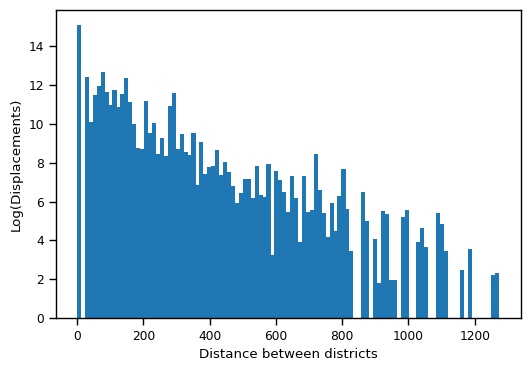

In [137]:
df_conc['bins'] = pd.cut(df_conc['dist_centroids'], bins=107)

# Group by bins and calculate the sum of 'Displacements' for each bin
bin_sums = df_conc.groupby('bins')['Displacements'].sum().reset_index()

# Calculate the mid-points of the bins for x-tick labels
bin_mids = bin_sums['bins'].apply(lambda x: x.mid)

# Create a bar plot with no space between the bars
plt.figure(figsize=(6,4))
plt.bar(bin_mids, np.log(bin_sums['Displacements']), width=np.diff(bin_mids)[0])

# Set x-tick labels to the mid-points of the bins, round to first decimal, and only put one label every 3 bins
#plt.xticks(bin_mids[::20], labels=[round(mid) for mid in bin_mids[::20]])
#plt.xticks linspace bin_mids[0], bin_mids[-1], 10
plt.xticklabels = np.round(np.linspace(bin_mids[0], bin_mids[-1:], 20), 1)


# Add labels and title
plt.xlabel('Distance between districts')
plt.ylabel('Log(Displacements)')

plt.show()

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


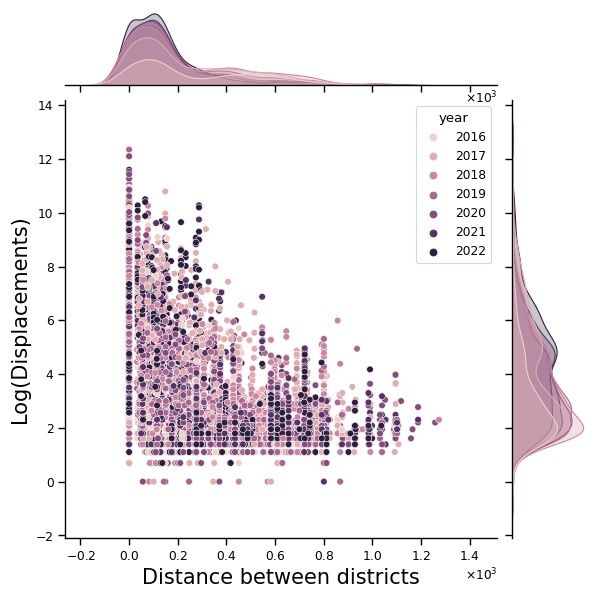

In [57]:
df_conc['Displacements_log'] = np.log(df_conc['Displacements'])
df_conc['dist_centroids_log'] = np.log(df_conc['dist_centroids'])
#change scatter dots size in jointplot
sns.set_context("paper")


g = sns.jointplot(x='dist_centroids', y='Displacements_log',  data=df_conc, hue='year')
g.ax_joint.set_xlabel('Distance between districts', fontsize=15)
g.ax_joint.set_ylabel('Log(Displacements)',  fontsize=15)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
g.ax_joint.xaxis.set_major_formatter(formatter)
#plt.savefig(r"/home/sara/Documenti/GitHub/Climate-and-conflict/pics/disp_dist_.pdf")
plt.show()

In [92]:
np.log(2.718281828459045)

0.9999999999999999

In [67]:
bins = np.histogram(df_conc['dist_centroids'], bins=10)[1]  # Get the bin edges
indices = np.digitize(df_conc['dist_centroids'], bins)  # Get the index of the bin each value falls into
#drop -inf

bin_sums = [y[indices == i].sum() for i in range(1, len(bins))]  # Sum y-values for each bin

plt.bar(bins[:-1], bin_sums, width=np.diff(bins))
plt.show()

NameError: name 'y' is not defined

## Normalization

In [32]:
col2 =['conflicts_dep', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr',
       'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr',
       'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr',
       'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr',
       'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr',
       'DL_lag6_arr', 'conflicts_lag1_arr', 'conflicts_lag2_arr',
       'conflicts_lag3_arr', 'conflicts_lag4_arr', 'conflicts_lag5_arr',
       'conflicts_lag6_arr', 'gdp_mean_arr', 'pop_count_arr', 'gdp_mean_dep',
       'pop_count_dep', 'sum_disp_arr', 'Displacements', 'Disp_pop_norm', 'dist_centroids']

In [33]:
df_conc_norm = df_conc.copy()

min_max_scaler = MinMaxScaler().fit(df_conc[col2])
df_conc_norm[col2] = min_max_scaler.transform(df_conc[col2])

## Add logged variables

In [34]:
#find columns with -inf
df_conc_norm[col2]= df_conc_norm[col2].replace(0, 0.001)

for col in col2:
    df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])

/tmp/ipykernel_40072/3749050344.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_40072/3749050344.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_40072/3749050344.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [35]:
#df_conc_norm.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_districts_c_dist.csv", index=False)

In [36]:
df_conc

,time,Previous (Departure) District,admin2_dep,tmx_dep,pre_dep,conflicts_dep,year,TA_dep,PA_dep,DL_dep,...,Current (Arrival) District,Displacements,gdp_mean_arr,pop_count_arr,gdp_mean_dep,pop_count_dep,dist_centroids,Disp_pop_norm,Displacements_log,dist_centroids_log
0,2016-05,Adan Yabaal,Adan Yabaal,32.900000,77.400000,6.0,2016,0.511460,0.126317,16,...,Adan Yabaal,10200,0.006433,99457.265625,0.006433,99457.265625,0.000000,0.102557,9.230143,-inf
1,2016-08,Adan Yabaal,Adan Yabaal,31.250000,13.700001,0.0,2016,0.290617,0.128469,19,...,Adan Yabaal,412,0.006433,99457.265625,0.006433,99457.265625,0.000000,0.004142,6.021023,-inf
2,2017-11,Adan Yabaal,Adan Yabaal,32.450000,59.350000,0.0,2017,0.040604,0.126130,34,...,Adan Yabaal,8,0.006433,99457.265625,0.006433,99457.265625,0.000000,0.000080,2.079442,-inf
3,2020-10,Adan Yabaal,Adan Yabaal,32.550003,71.350006,0.0,2020,0.187053,0.090441,10,...,Adan Yabaal,83,0.006433,99457.265625,0.006433,99457.265625,0.000000,0.000835,4.418841,-inf
4,2021-03,Adan Yabaal,Adan Yabaal,34.400000,18.850000,0.0,2021,0.157298,0.139288,15,...,Adan Yabaal,121,0.006433,99457.265625,0.006433,99457.265625,0.000000,0.001217,4.795791,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11880,2022-11,Borama,Borama,29.700000,13.200000,0.0,2022,1.138843,-0.088227,16,...,Zeylac,10,0.003624,45399.246094,0.039300,353402.062500,57.290819,0.000220,2.302585,4.048140
11881,2022-11,Lughaye,Lughaye,33.400000,9.800000,0.0,2022,1.142411,-0.090951,16,...,Zeylac,131,0.003624,45399.246094,0.005782,57644.421875,49.750583,0.002886,4.875197,3.907022
11882,2022-11,Zeylac,Zeylac,32.600000,12.500000,0.0,2022,1.123624,-0.071045,16,...,Zeylac,116,0.003624,45399.246094,0.003624,45399.246094,0.000000,0.002555,4.753590,-inf
11883,2022-12,Lughaye,Lughaye,31.500000,1.400000,0.0,2022,1.487571,-0.188400,17,...,Zeylac,45,0.003624,45399.246094,0.005782,57644.421875,49.750583,0.000991,3.806662,3.907022
